In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

## Simple approximations of functions

In a feed forward neural network you pass the activation of a previous layer into a next layer and subsequently use a non-linear activation. This is chained for a number of layers and in the end either a linear, logistic, or softmax activation is used to give a regression, binary, or K-class classification. First we show the output of the hidden nodes before the output layer for various functions

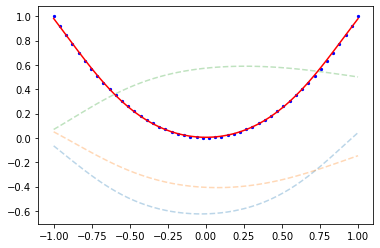

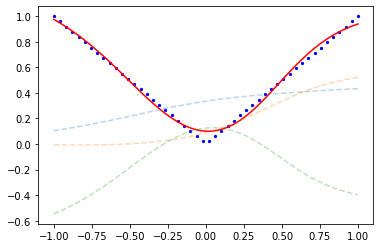

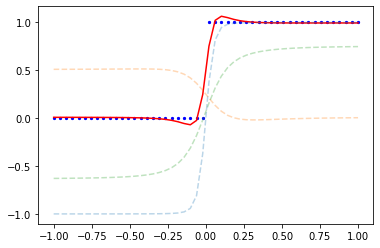

In [2]:
for function in [lambda x: np.power(x, 2), lambda x: np.abs(x), lambda x: 1 if x > 0 else 0]:
    num_examples = 50
    function_x = torch.from_numpy(np.linspace(-1, 1, num_examples)).float()
    function_y = torch.from_numpy(np.array(list(map(function, function_x))).reshape(num_examples, 1)).float()
    input_ = function_x.reshape(num_examples, 1)

    model = nn.Sequential(
        nn.Linear(1, 3),
        nn.Tanh(),
        nn.Linear(3, 3),
        nn.Tanh(),
        nn.Linear(3, 3),
        nn.Tanh(),
        nn.Linear(3, 1)
    )

    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    loss_func = nn.MSELoss()

    for i in range(4000):
        optimizer.zero_grad()

        predictions = model.forward(input_)
        loss = loss_func(input=predictions, target=function_y)

        loss.backward()
        optimizer.step()

    plt.figure()
    plt.plot(function_x.flatten(), predictions.detach().numpy(), c='r')
    plt.scatter(function_x.flatten(), function_y.flatten(), c='b', s=5)
    for index in range(3):
        plt.plot(function_x, model[:6].forward(input_)[:,index].flatten().detach().numpy(), alpha=0.30, linestyle='dashed')
    plt.show()

## Network learning

The model is trained by defining multiple layers (activations) and subsequently applying an activation to all the nodes in there layers. A commmon method is the sigmoid activation

$$
    \sigma(a) = \frac{1}{1 + e^{-a}}
$$

Wherer a is a linear trannsformation with added bias, i.e. $a_i = \sum_{i=0}^Dw^{(1)}_{ji}x_i$ So a two-layer (1 input, 2 hidden) could be defined as 

$$
    y_{k}(x,w) = \sigma((\sum_{i=0}^Mw^{(2)}_{ji}x_i)\sigma(\sum_{i=0}^Dw^{(1)}_{ji}x_i))
$$

So the activation for a certain class $k$ given input x and weight matrix w is a linear combination of 2 times a linear transformation. Another common activation function is the hyperbolic tangent 

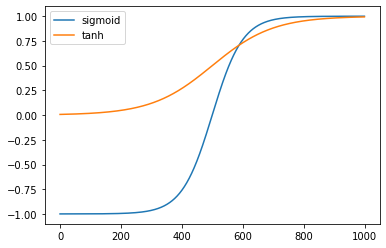

In [3]:
sigmoid = lambda x : 1 / (1 + np.exp(-x))
x_input = np.linspace(-5, 5, 1000)
plt.plot(np.tanh(x_input), label='sigmoid')
plt.plot([sigmoid(x) for x in x_input], label='tanh')
plt.legend()
plt.show()

It can be easily shown (even visualy) that the tanh function is just a scaling of the sigmoidal function, specifically 

$$
    tanh(a) =  \frac{e^a - e^{-a}}{e^a + e^{-a}} = 2 * \sigma(2 * a) - 1 
$$

This also means that the weights are a linear transformation from the sigmoidal function because

$$
    a^s = w^tx \\
    a^t = 2 * w^tx
$$

## Neural Networks for regression

So the activation of the tangent function is just 2 times the activation of the sigmoid. Optimilization is performed by again using the maximum likelihood method. Assume that the target follows a gaussian distribution, to optimize the negative log likelihood we have

$$
    - ln \; \Pi \; p(t|x,w) \\
    - ln \; \Pi \;N(t|y(x,w), \beta^{-1} I ) \\
    - \sum_{i=1}^{N} - \frac{\beta}{2} (y(x, w) - t)^T(y(x, w) - t) \\
    \sum_{i=1}^{N} (y(x, w) - t)^2
$$

This indedd is the standard optimization problem as seen in normal regression. Using an interative optimization problem (since the gradient is still dependent on w) you can determine the optimal value for w by setting the derivative and subsequently determine the value for the precision. So the conclusion of the first few pages is that optimizing a regression problem with a neural network under the assumption that the target variable is normally distributed gives the same optimization problems as in normal regression 

## Neural Networks for classification

If you use a single node layer with a logistic sigmoid activation as the last layer we can look at the neural network as determining the class conditional probabiility of seeing class $C_1$ given the network weights

$$
    y(x,w) = P(C_1 | x)
$$

You can then write the conditional probability of a target variable t being t by

$$
    p(t|w,x) = y(x, w)^t(1 - y(x,w))^{1-t}
$$

Again, taking the negative log likelihood gives

$$
    p(t|w,x) = \prod_{k=1}^Ky(x, w)^t(1 - y(x,w))^{1-t} \\
    ln p(t|w,x) = \sum_{k=1}^Kt \; ln(y(x, w)) + (1 - t) \; ln(1 - y(x,w))
$$

Setting the derivative for a 

## Mixture Density Networks

Most practical problems will not have a simple gaussian error. These multimodal functions can be approximated using a mixture density network

In [4]:
import numpy as np

num_examples = 300

true_function = lambda x : x + (0.3 * np.sin(2 * np.pi * x))

x = np.random.uniform(0, 1, num_examples)
t = true_function(x) + (np.random.uniform(-0.1, 0.1, num_examples))
t_inv = np.random.uniform(0, 1, num_examples)
x_inv = true_function(t_inv) + (np.random.uniform(-0.1, 0.1, num_examples))

model = nn.Sequential(
    nn.Linear(1, 6),
    nn.Tanh(),
    nn.Linear(6, 6),
    nn.Tanh(),
    nn.Linear(6, 1)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
loss_func = torch.nn.MSELoss(reduction='sum')

all_losses = []

for i in range(20000):
    optimizer.zero_grad()
    
    prediction = model.forward(torch.from_numpy(x_inv).float().reshape(-1, 1))
    loss = loss_func(prediction, torch.from_numpy(t_inv).float().reshape(-1, 1))
    
    all_losses.append(loss.item())
    
    loss.backward()
    
    optimizer.step()

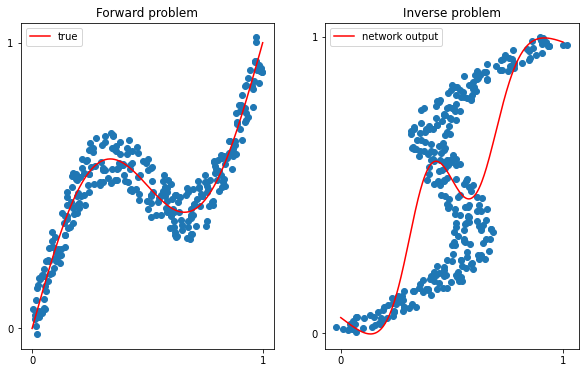

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
axes[0].set_title('Forward problem')
axes[0].scatter(x, t)
axes[0].plot(np.linspace(0, 1, num_examples), true_function(np.linspace(0, 1, num_examples)), c='r', label='true')
axes[0].set_xticks(np.linspace(0, 1, 2))
axes[0].set_yticks(np.linspace(0, 1, 2))
axes[0].legend()
axes[1].set_title('Inverse problem')
axes[1].scatter(t, x)
predictions = model(torch.from_numpy(np.linspace(0, 1, num_examples)).float().reshape(-1, 1)).detach().numpy().flatten()
axes[1].plot(np.linspace(0, 1, num_examples), predictions, c='r', label='network output')
axes[1].set_xticks(np.linspace(0, 1, 2))
axes[1].set_yticks(np.linspace(0, 1, 2))
plt.legend()
plt.show()

Since this problem is not gaussian the fit to the problem is poor. We can solve this by learning the parameters (mean, variance, and mixing coefficients

In [91]:
class MixtureGaussians(nn.Module):
    def __init__(self):
        super(MixtureGaussians, self).__init__()
        
        self.base_model = nn.Sequential(
            nn.Linear(1, 6),
            nn.Tanh(),
            nn.Linear(6, 6),
            nn.Tanh()
        )
        
        self.means = nn.Linear(6, 3)
        self.variances = nn.Linear(6, 3)
        self.coeficients = nn.Linear(6, 3)
        
        
        self.softmax = nn.Softmax(dim=-1)
        
    
    def forward(self, x):
        representations = self.base_model(x)
        
        coefficients = self.softmax(self.means(representations))
        variances = torch.exp(self.variances(representations))
        means = self.means(representations)
        
        return coefficients, torch.distributions.Normal(means, variances)
    
    def loss_func(self, input_, target):
        pi, normal = self.forward(input_)
        
        loglik = normal.log_prob(target.unsqueeze(1).expand_as(normal.loc))
        loglik = torch.sum(loglik, dim=1)
        
        loss = -torch.logsumexp(torch.log(pi) + loglik, dim=1)
        
        return loss

In [96]:
target_tensor.shape

torch.Size([1, 1])

In [95]:
input_tensor.shape

torch.Size([1, 1])

In [92]:
mg = MixtureGaussians()
target_tensor = torch.from_numpy(t_inv).float().reshape(-1, 1)[:1]
input_tensor = torch.from_numpy(x_inv).float().reshape(-1, 1)[:1]

optimizer = torch.optim.SGD(mg.parameters(), lr=0.001)

all_loss = []
dms = []

for i in range(1000):
    optimizer.zero_grad()

    loss = mg.loss_func(input_tensor, target_tensor)
    
    loss.backward()
    all_loss.append(loss)
    
    optimizer.step()
    

RuntimeError: expand(torch.FloatTensor{[1, 1, 1]}, size=[1, 3]): the number of sizes provided (2) must be greater or equal to the number of dimensions in the tensor (3)

In [68]:
y.unsqueeze(1).shape

torch.Size([5, 1, 1])

In [99]:
import torch
import torch.nn as nn
from torch.distributions import Normal, OneHotCategorical


class MixtureDensityNetwork(nn.Module):
    """
    Mixture density network.
    [ Bishop, 1994 ]
    Parameters
    ----------
    dim_in: int; dimensionality of the covariates
    dim_out: int; dimensionality of the response variable
    n_components: int; number of components in the mixture model
    """
    def __init__(self, dim_in, dim_out, n_components):
        super().__init__()
        self.pi_network = CategoricalNetwork(dim_in, n_components)
        self.normal_network = MixtureDiagNormalNetwork(dim_in, dim_out,
                                                       n_components)

    def forward(self, x):
        return self.pi_network(x), self.normal_network(x)

    def loss(self, x, y):
        pi, normal = self.forward(x)
        print(normal.loc.shape)
        loglik = normal.log_prob(y.unsqueeze(1).expand_as(normal.loc))
        loglik = torch.sum(loglik, dim=2)
        print(loglik)
        print(loglik.shape)
        print(pi)
        print(pi.probs.shape)
        loss = -torch.logsumexp(torch.log(pi.probs) + loglik, dim=1)
        return loss

    def sample(self, x):
        pi, normal = self.forward(x)
        samples = torch.sum(pi.sample().unsqueeze(2) * normal.sample(), dim=1)
        return samples


class MixtureDiagNormalNetwork(nn.Module):

    def __init__(self, in_dim, out_dim, n_components, hidden_dim=None):
        super().__init__()
        self.n_components = n_components
        if hidden_dim is None:
            hidden_dim = in_dim
        self.network = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, 2 * out_dim * n_components),
        )

    def forward(self, x):
        params = self.network(x)
        mean, sd = torch.split(params, params.shape[1] // 2, dim=1)
        mean = torch.stack(mean.split(mean.shape[1] // self.n_components, 1))
        sd = torch.stack(sd.split(sd.shape[1] // self.n_components, 1))
        print(mean.shape)
        print(mean.transpose(0, 1).shape)
        return Normal(mean.transpose(0, 1), torch.exp(sd).transpose(0, 1))

class CategoricalNetwork(nn.Module):

    def __init__(self, in_dim, out_dim, hidden_dim=None):
        super().__init__()
        if hidden_dim is None:
            hidden_dim = in_dim
        self.network = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        params = self.network(x)
        return OneHotCategorical(logits=params)

In [100]:
x = torch.randn(5, 1)
y = torch.randn(5, 1)

# 1D input, 1D output, 3 mixture components
model = MixtureDensityNetwork(1, 1, 3)
pred_parameters = model(x)

# use this to backprop
loss = model.loss(x, y)

# use this to sample a trained model
samples = model.sample(x)

torch.Size([3, 5, 1])
torch.Size([5, 3, 1])
torch.Size([3, 5, 1])
torch.Size([5, 3, 1])
torch.Size([5, 3, 1])
tensor([[-2.3896, -0.7197, -0.6143],
        [-0.9047, -2.4025, -2.5779],
        [-2.1883, -1.4669, -0.9085],
        [-3.1355, -2.9454, -1.0860],
        [-2.2911, -3.1692, -1.4705]], grad_fn=<SumBackward1>)
torch.Size([5, 3])
OneHotCategorical()
torch.Size([5, 3])
torch.Size([3, 5, 1])
torch.Size([5, 3, 1])


In [62]:
y.unsqueeze(1).expand_as(normal.loc)

RuntimeError: expand(torch.FloatTensor{[5, 1, 1]}, size=[10, 3]): the number of sizes provided (2) must be greater or equal to the number of dimensions in the tensor (3)

In [56]:
normal.loc

tensor([[-0.1192, -0.1584,  0.3505],
        [-0.0831, -0.1808,  0.3371],
        [-0.1580, -0.1338,  0.3613],
        [-0.0865, -0.1788,  0.3385],
        [-0.0924, -0.1752,  0.3408],
        [-0.0840, -0.1803,  0.3375],
        [-0.1199, -0.1580,  0.3507],
        [-0.0288, -0.2125,  0.3120],
        [-0.0908, -0.1762,  0.3402],
        [-0.0912, -0.1759,  0.3403]], grad_fn=<AddmmBackward>)